# Visualization & community detection

In [1]:
import networkx as nx
import math

from cdlib import viz, algorithms
from cdlib.classes import NodeClustering

from stock_graph_creation import get_sp500_stocks
from stock_graph_creation import correlation_to_graph, correlation_to_pos_neg_graphs

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'graph_tool', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [28]:
correlations = get_sp500_stocks(start_date="2025-02-01", end_date="2025-03-01").corr()
G_pos, G_neg = correlation_to_pos_neg_graphs(correlations, threshold=0.8)

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-02-01 -> 2025-03-01)')


In [29]:
import matplotlib.pyplot as plt

def info(G, fast = False):
  print("{:>12s} | '{:s}'".format('Graph', G.name))

  n = G.number_of_nodes()
  m = G.number_of_edges()
  
  print("{:>12s} | {:,d} ({:,d})".format('Nodes', n, nx.number_of_isolates(G)))
  print("{:>12s} | {:,d} ({:,d})".format('Edges', m, nx.number_of_selfloops(G)))
  print("{:>12s} | {:.2f} ({:,d})".format('Degree', 2 * m / n, max([k for _, k in G.degree()])))

  if not fast:
    C = sorted(nx.connected_components(nx.MultiGraph(G)), key = len, reverse = True)

    print("{:>12s} | {:.1f}% ({:,d})".format('LCC', 100 * len(C[0]) / n, len(C)))

    print("{:>12s} | {:.4f}".format('Clustering', nx.average_clustering(G if type(G) == nx.Graph else nx.Graph(G))))
    
    C = algorithms.leiden(G)
    Q = C.newman_girvan_modularity().score
      
    print("{:>12s} | {:.4f} ({:,d})".format('Modularity', Q, len(C.communities)))
  print()

def plot_wiring_diagram(G, layout = None, C = None, S = None, label = "wiring", save_file = True):
  if layout is None:
    layout = nx.spring_layout(G)
    
  colors = None
  if C is not None:
    colors = [0] * len(G)
    for c, comm in enumerate(C.communities):
      for i in comm:
        colors[i] = c
    
  sizes = None
  if S is not None:
    sizes = [100 * len(G)] * len(G)
    for i in G.nodes():
      sizes[i] *= S[i]
  
  labels = {i: "" if G.nodes[i]['label'].isdigit() else G.nodes[i]['label'] for i in G.nodes()}
  
  plt.figure()

  nx.draw(G, pos = layout, node_color = colors, node_size = sizes, labels = labels, font_size = 5, edge_color = 'gray')
  
  if save_file:
    plt.savefig(G.name + "." + label + ".pdf", bbox_inches = 'tight')
  else:
    plt.show()
  plt.close()

def plot_block_model(G, C, save_file=False):
  plt.figure(figsize=(10, 10))
  
  C = sorted(C.communities, key = len)
  nodes = [i for c in C for i in c]
  A = nx.adjacency_matrix(G, nodelist = nodes).todense()
  
  plt.imshow(A, cmap = 'binary', interpolation = 'nearest')
  
  xy = 0
  for c in C[:-1]:
    xy += len(c)
    
    plt.plot([xy - 0.5, xy - 0.5], [-0.5, len(G) - 0.5], '-g')
    plt.plot([-0.5, len(G) - 0.5], [xy - 0.5, xy - 0.5], '-g')

  plt.yticks(range(len(G)), labels = [G.nodes[i]['label'] for i in nodes], size = 2)
  plt.xticks([])
  
  if save_file:
    plt.savefig(G.name + ".blocks.pdf", bbox_inches = 'tight')
  else:
    plt.show()
  plt.close()

In [30]:
info(G_pos)

       Graph | 'pos_correlations'
       Nodes | 503 (47)
       Edges | 7,538 (0)
      Degree | 29.97 (91)
         LCC | 90.3% (49)
  Clustering | 0.5279
  Modularity | 0.5527 (55)



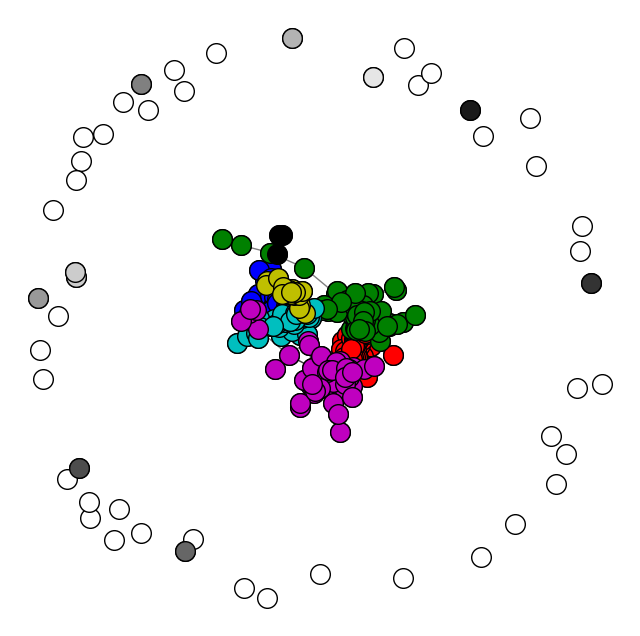

In [31]:
algs = {
    "Graph": lambda G: NodeClustering([range(len(G))],G, 'Graph'),
    "Isolates": lambda G: NodeClustering([[i] for i in range(len(G))], G, 'Isolates'),
    "MCL": algorithms.markov_clustering,
    "EMMM": lambda G: algorithms.em(G, k = 4), #expectation maximization
    "KL": lambda G: NodeClustering([list(c) for c in nx.community.kernighan_lin_bisection(G)], G, "KL"),
    "Louvain": lambda G: algorithms.louvain(G),
    "Leiden": lambda G: algorithms.leiden(G),
    "Infomap": lambda G: algorithms.infomap(G),
    "LP": lambda G: algorithms.label_propagation(G),
    "FLP": lambda G: NodeClustering([list(c) for c in nx.community.fast_label_propagation_communities(G)], G, "Fast LP")
}

    
viz.plot_network_clusters(G_pos, algs["Louvain"](G_pos), nx.spring_layout(G_pos))

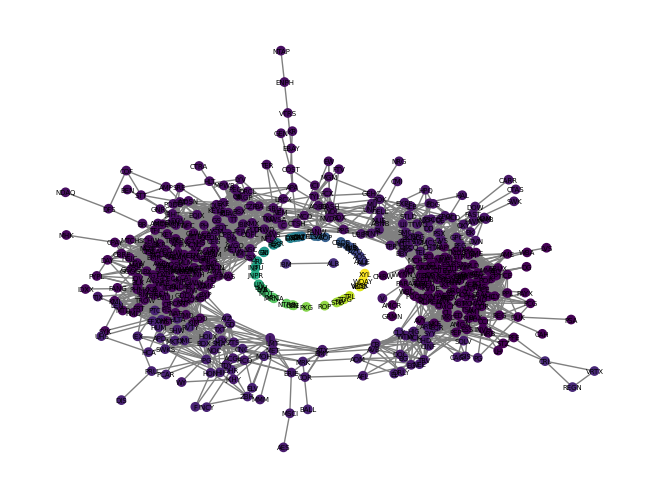

In [32]:
plot_wiring_diagram(G_pos, nx.kamada_kawai_layout(G_pos), algs["Leiden"](G_pos), save_file=False)

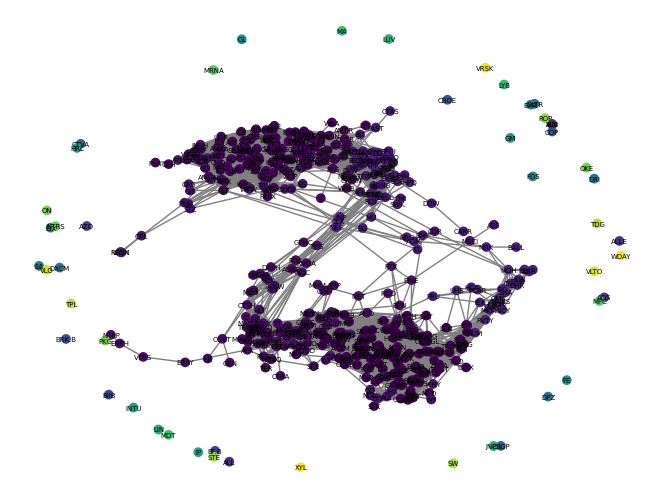

In [33]:
plot_wiring_diagram(G_pos, nx.forceatlas2_layout(G_pos), algs["Louvain"](G_pos), save_file=False)

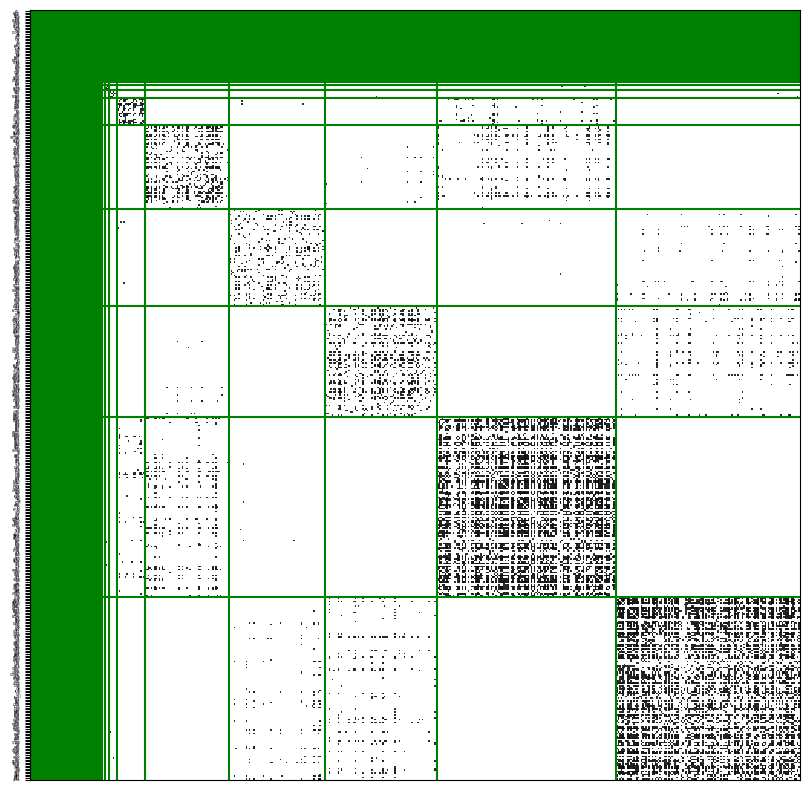

In [34]:
plot_block_model(G_pos, algs["Leiden"](G_pos), save_file=False)

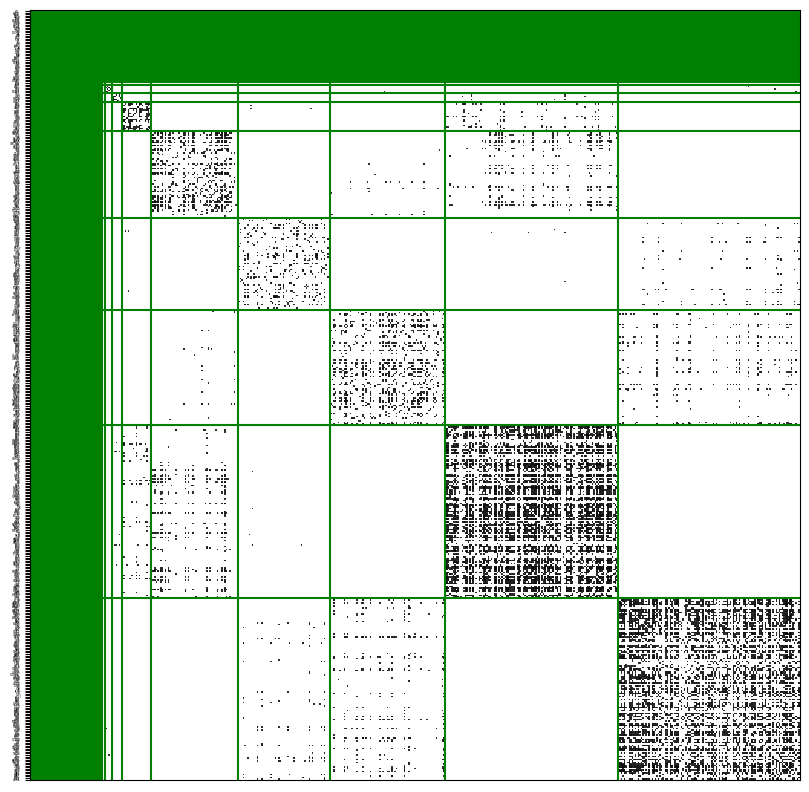

In [35]:
plot_block_model(G_pos, algs["Louvain"](G_pos), save_file=False)

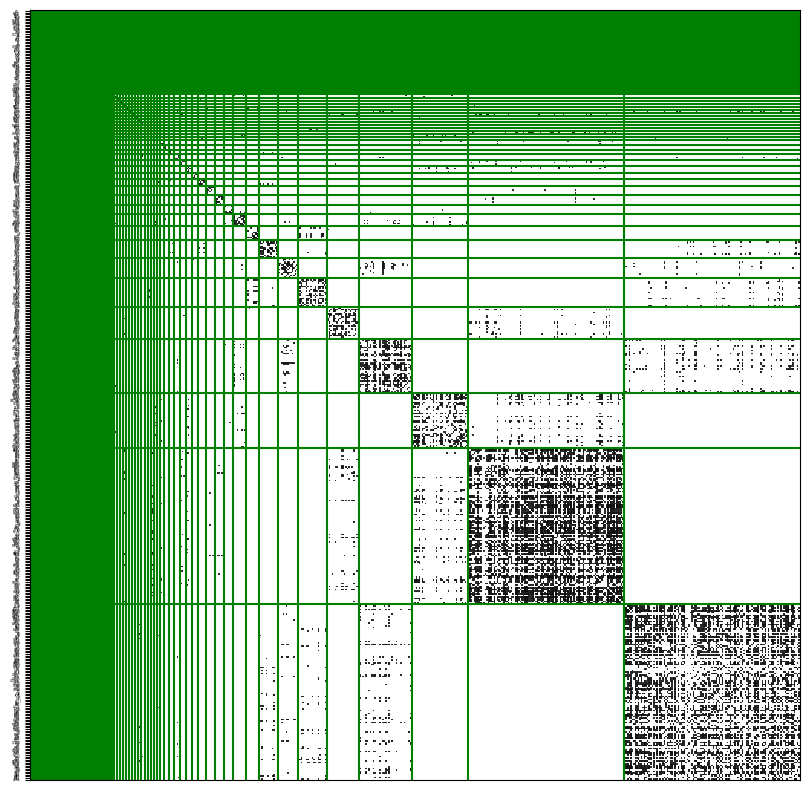

In [36]:
plot_block_model(G_pos, algs["MCL"](G_pos), save_file=False)

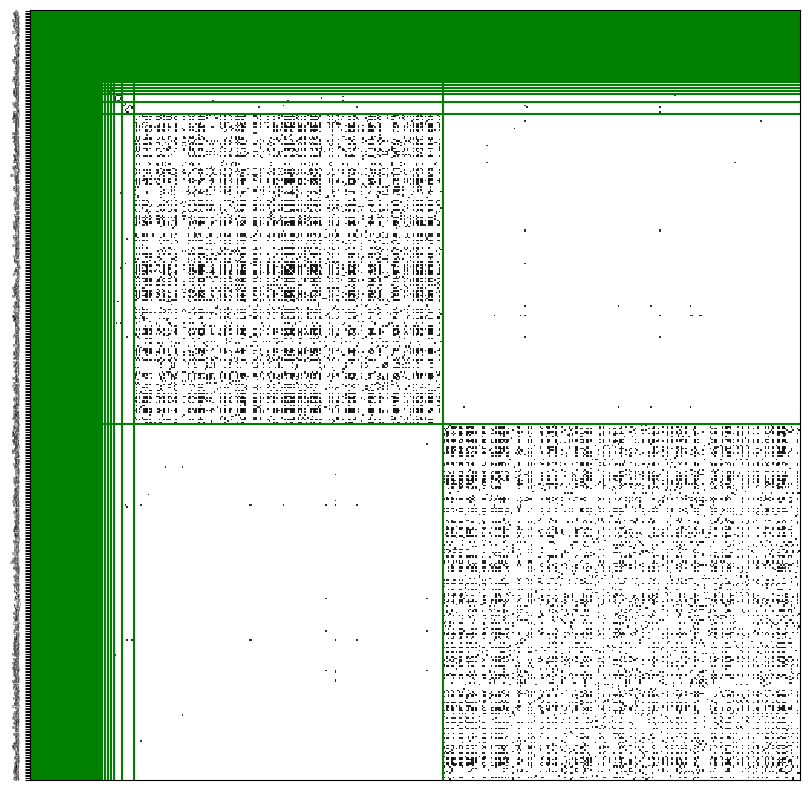

In [37]:
plot_block_model(G_pos, algs["FLP"](G_pos), save_file=False)

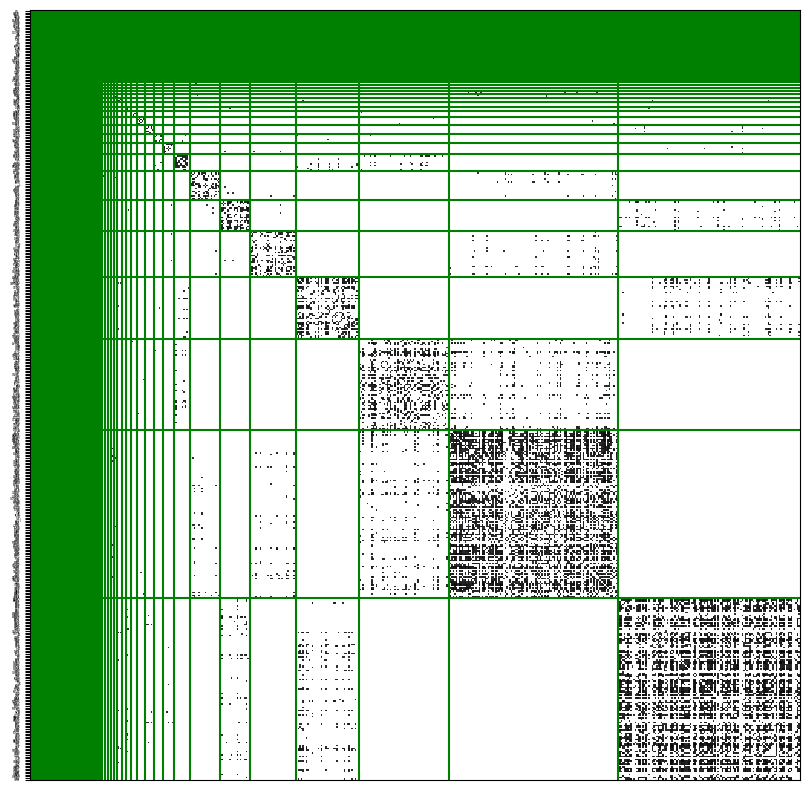

In [38]:
plot_block_model(G_pos, algs["Infomap"](G_pos), save_file=False)

Most of the community detection algorithms seem to find two well-defined quite large communities plus some smaller communities. Let's find out which stocks form these communities.

In [39]:
communities = algs["Leiden"](G_pos).communities
len(communities)

55

In [40]:
for i, community in enumerate(communities):
    print(f"{i}: {len(community)} nodes")

0: 124 nodes
1: 114 nodes
2: 87 nodes
3: 45 nodes
4: 44 nodes
5: 37 nodes
6: 3 nodes
7: 2 nodes
8: 1 nodes
9: 1 nodes
10: 1 nodes
11: 1 nodes
12: 1 nodes
13: 1 nodes
14: 1 nodes
15: 1 nodes
16: 1 nodes
17: 1 nodes
18: 1 nodes
19: 1 nodes
20: 1 nodes
21: 1 nodes
22: 1 nodes
23: 1 nodes
24: 1 nodes
25: 1 nodes
26: 1 nodes
27: 1 nodes
28: 1 nodes
29: 1 nodes
30: 1 nodes
31: 1 nodes
32: 1 nodes
33: 1 nodes
34: 1 nodes
35: 1 nodes
36: 1 nodes
37: 1 nodes
38: 1 nodes
39: 1 nodes
40: 1 nodes
41: 1 nodes
42: 1 nodes
43: 1 nodes
44: 1 nodes
45: 1 nodes
46: 1 nodes
47: 1 nodes
48: 1 nodes
49: 1 nodes
50: 1 nodes
51: 1 nodes
52: 1 nodes
53: 1 nodes
54: 1 nodes


Lets slook at two largest communities.

### 1st largest community

In [41]:
community_1 = communities[0]
subgraph_1 = nx.induced_subgraph(G_pos, community_1)
info(subgraph_1)

       Graph | 'pos_correlations'
       Nodes | 124 (0)
       Edges | 2,899 (0)
      Degree | 46.76 (85)
         LCC | 100.0% (1)
  Clustering | 0.7046
  Modularity | 0.1660 (3)



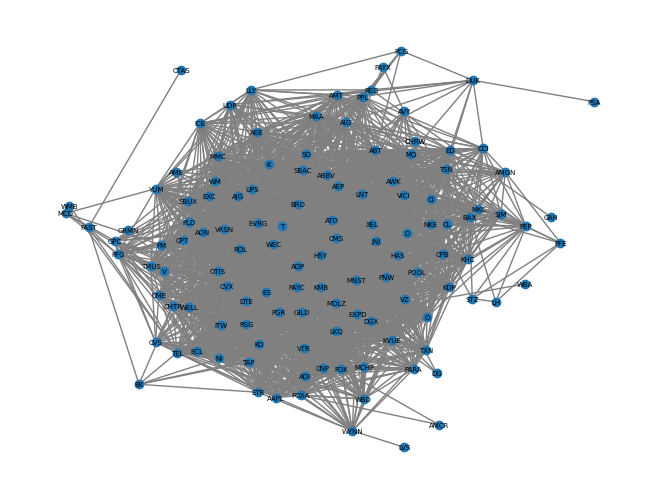

In [42]:
plot_wiring_diagram(subgraph_1, nx.forceatlas2_layout(subgraph_1), save_file=False)

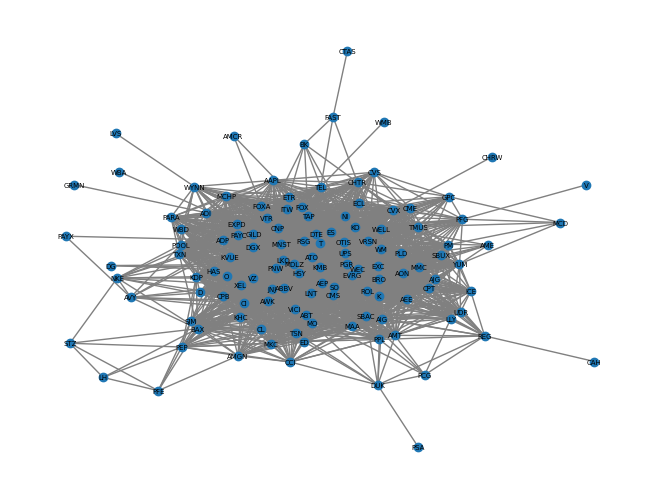

In [43]:
plot_wiring_diagram(subgraph_1, nx.kamada_kawai_layout(subgraph_1), save_file=False)

In [48]:
subgraph_1_labels = [data["label"] for _, data in subgraph_1.nodes(data=True)]
subgraph_1_labels

['AAPL',
 'ABBV',
 'ABT',
 'ADI',
 'ADP',
 'AEE',
 'AEP',
 'AIG',
 'AJG',
 'AMCR',
 'AME',
 'AMGN',
 'AMT',
 'AON',
 'ATO',
 'AVY',
 'AWK',
 'BAX',
 'BK',
 'BRO',
 'CAH',
 'CCI',
 'CHRW',
 'CHTR',
 'CI',
 'CL',
 'CME',
 'CMS',
 'CNP',
 'CPB',
 'CPT',
 'CTAS',
 'CVS',
 'CVX',
 'D',
 'DG',
 'DGX',
 'DTE',
 'DUK',
 'ECL',
 'ED',
 'ES',
 'ETR',
 'EVRG',
 'EXC',
 'EXPD',
 'FAST',
 'FOX',
 'FOXA',
 'GILD',
 'GPC',
 'GRMN',
 'HAS',
 'HSY',
 'ICE',
 'ITW',
 'JNJ',
 'K',
 'KDP',
 'KHC',
 'KMB',
 'KO',
 'KVUE',
 'LH',
 'LKQ',
 'LLY',
 'LNT',
 'LVS',
 'MAA',
 'MCD',
 'MCHP',
 'MDLZ',
 'MKC',
 'MMC',
 'MNST',
 'MO',
 'NI',
 'NKE',
 'O',
 'OTIS',
 'PARA',
 'PAYC',
 'PAYX',
 'PCG',
 'PEP',
 'PFE',
 'PFG',
 'PGR',
 'PLD',
 'PM',
 'PNW',
 'POOL',
 'PPL',
 'PSA',
 'REG',
 'ROL',
 'RSG',
 'SBAC',
 'SBUX',
 'SJM',
 'SO',
 'STZ',
 'T',
 'TAP',
 'TEL',
 'TMUS',
 'TSN',
 'TXN',
 'UDR',
 'UPS',
 'V',
 'VICI',
 'VRSN',
 'VTR',
 'VZ',
 'WBA',
 'WBD',
 'WEC',
 'WELL',
 'WM',
 'WMB',
 'WYNN',
 'XEL',
 'YUM']

### 2nd largest community

In [44]:
community_2 = communities[1]
subgraph_2 = nx.induced_subgraph(G_pos, community_2)
info(subgraph_2)

       Graph | 'pos_correlations'
       Nodes | 114 (0)
       Edges | 2,697 (0)
      Degree | 47.32 (88)
         LCC | 100.0% (1)
  Clustering | 0.7296
  Modularity | 0.1790 (3)



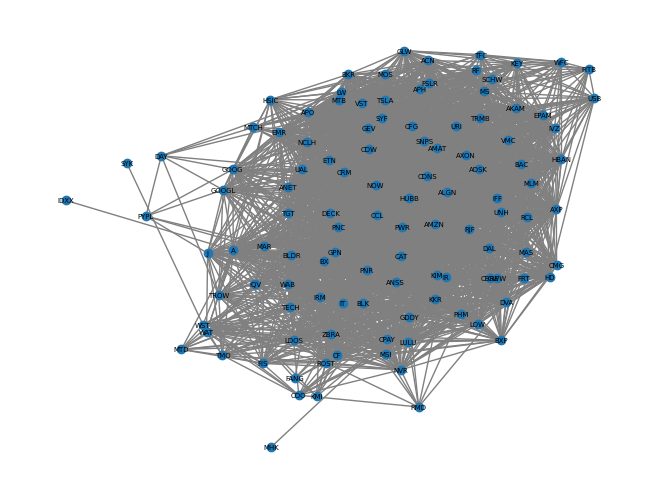

In [45]:
plot_wiring_diagram(subgraph_2, nx.forceatlas2_layout(subgraph_2), save_file=False)

In [49]:
subgraph_2_labels = [data["label"] for _, data in subgraph_2.nodes(data=True)]
subgraph_2_labels

['A',
 'ACN',
 'ADSK',
 'AKAM',
 'ALGN',
 'AMAT',
 'AMZN',
 'ANET',
 'ANSS',
 'APH',
 'APO',
 'AXON',
 'AXP',
 'BAC',
 'BKR',
 'BLDR',
 'BLK',
 'BX',
 'BXP',
 'CAT',
 'CBRE',
 'CCL',
 'CDNS',
 'CDW',
 'CF',
 'CFG',
 'CMG',
 'COO',
 'CPAY',
 'CRM',
 'DAL',
 'DAY',
 'DECK',
 'DVA',
 'EMR',
 'EPAM',
 'ETN',
 'FANG',
 'FIS',
 'FITB',
 'FRT',
 'FSLR',
 'GDDY',
 'GEV',
 'GLW',
 'GOOG',
 'GOOGL',
 'GPN',
 'GWW',
 'HBAN',
 'HD',
 'HSIC',
 'HUBB',
 'IDXX',
 'IFF',
 'IQV',
 'IR',
 'IRM',
 'IT',
 'IVZ',
 'J',
 'KEY',
 'KIM',
 'KKR',
 'KMI',
 'LDOS',
 'LOW',
 'LULU',
 'LW',
 'MAR',
 'MAS',
 'MHK',
 'MLM',
 'MOS',
 'MS',
 'MSI',
 'MTB',
 'MTCH',
 'MTD',
 'NCLH',
 'NOW',
 'NVR',
 'PHM',
 'PNC',
 'PNR',
 'PWR',
 'PYPL',
 'RCL',
 'RF',
 'RJF',
 'RMD',
 'ROST',
 'SCHW',
 'SNPS',
 'SYF',
 'SYK',
 'TECH',
 'TFC',
 'TGT',
 'TMO',
 'TRMB',
 'TROW',
 'TSLA',
 'UAL',
 'UNH',
 'URI',
 'USB',
 'VMC',
 'VST',
 'WAB',
 'WAT',
 'WFC',
 'WST',
 'ZBRA']